In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, ConcatDataset
import os
import json
import pickle
from typing import List
from torchmetrics.text import CharErrorRate

config = json.load(open('config.json'))["fine-tuning"]
ssl_config = json.load(open('config.json'))["SSL"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from custom_dataset import DecoderDataset
from encoder import Encoder
from Decoder import LSTMAttnDecoder

with open(config["char to token"], 'rb') as f:
    char_to_token = pickle.load(f)

In [3]:
with open(config["token to char"], "rb") as f:
    token_to_char = pickle.load(f)

def tokenizer_func(input_list: List[torch.tensor]) -> List[str]:
    return [token_to_char[index.item()] for index in input_list]

In [4]:
torch.manual_seed(0)
encoder = Encoder().to(device)
decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
if config["fine-tune on other dataset"]:
	print("fine-tuning on other dataset")
	print("load", config["Encoder path for fine-tuning"])
	encoder.load_state_dict(torch.load(config["Encoder path for fine-tuning"]))
	print("load", config["Decoder path for fine-tuning"])
	decoder.load_state_dict(torch.load(config["Decoder path for fine-tuning"]))
else:
	print("not fine-tuning on other dataset")
	print("load", ssl_config["saved Encoder path"])
	# encoder.load_state_dict(torch.load(ssl_config["saved Encoder path"]))

if config["Freeze Encoder"]:
	print("Freezing Encoder")
	for param in encoder.parameters():
		param.requires_grad = False

not fine-tuning on other dataset
load models/encoder_8_09.pt


In [5]:
torch.manual_seed(0)
decoder_dataset = []
for i in range(1, 4):
	if config[f"dataset {i}"] is not None and config[f"dataset {i} csv"] is not None:
		decoder_dataset.append(DecoderDataset(config[f"dataset {i} csv"], config[f"dataset {i}"], char_to_token))
decoder_dataset = ConcatDataset(decoder_dataset)
train_size = int(0.9 * len(decoder_dataset))
val_size = len(decoder_dataset) - train_size
train_dataset, val_dataset = random_split(decoder_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=config["Batch size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["Batch size"], shuffle=False)

In [6]:
len(decoder_dataset), len(train_dataset), len(val_dataset)

(5690, 5121, 569)

In [7]:
criterion = CrossEntropyLoss()
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=config["start lr"])
scheduler = StepLR(optimizer, step_size=config["lr scheduler step size"], gamma=0.1)
cer = CharErrorRate()

In [8]:
torch.manual_seed(0)

epochs = config["epoch size"]
SOS_token = char_to_token['<SOS>']
train_cer_list = []
train_steps = []
step = 0
val_cer_list = []
val_steps = []

for epoch in range(epochs):
    # Training loop
    decoder.train()
    total_cer = 0
    for i, (imgs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        imgs, labels = imgs.to(device), labels.to(device)

        encoder_outputs, decoder_hidden = encoder(imgs)  # Encoder's forward pass
        decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)  # SOS token

        loss = 0
        predictions = []
        for t in range(labels.size(1)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, decoder_output_labels = torch.max(decoder_output, dim=1)

            loss += criterion(decoder_output, labels[:, t])
            predictions.append(decoder_output_labels.unsqueeze(0))

            decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing
        loss.backward()
        optimizer.step()
        step += 1

        if i % 100 == 0:
            predictions = torch.cat(predictions).transpose(0, 1)
            batch_cer = sum(cer(tokenizer_func(pred.view(-1)), tokenizer_func(label.view(-1))) for pred, label in
                         zip(predictions, labels)) / len(predictions)
            print(
                f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Loss: {loss.item()}, CER: {batch_cer}, LR: {scheduler.get_last_lr()[0]}")
            train_cer_list.append(batch_cer)
            train_steps.append(step)
    scheduler.step()

    # Validation loop
    decoder.eval()
    with torch.no_grad():  # Disable gradient calculation
        total_val_loss = 0
        total_val_cer = 0
        val_batch_count = 0
        for i, (imgs, labels) in enumerate(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            encoder_outputs, decoder_hidden = encoder(imgs)
            decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)

            loss = 0
            val_predictions = []
            for t in range(labels.size(1)):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, decoder_output_labels = torch.max(decoder_output, dim=1)

                loss += criterion(decoder_output, labels[:, t])
                val_predictions.append(decoder_output_labels.unsqueeze(0))

                decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing

            total_val_loss += loss.item()
            # Transpose and calculate CER
            val_predictions = torch.cat(val_predictions).transpose(0, 1)
            total_val_cer += sum(cer(tokenizer_func(pred.view(-1)), tokenizer_func(label.view(-1))) for pred, label in
                                 zip(val_predictions, labels)) / len(val_predictions)

        val_loss = total_val_loss / len(val_dataloader)
        val_cer = total_val_cer / len(val_dataloader)
        val_cer_list.append(val_cer)
        val_steps.append(step)

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation CER: {val_cer}, LR: {scheduler.get_last_lr()[0]}")

Epoch 1/30, Batch 0/161, Loss: 82.09620666503906, CER: 0.9895687103271484, LR: 0.0001
Epoch 1/30, Batch 100/161, Loss: 19.1047420501709, CER: 0.15026849508285522, LR: 0.0001
Epoch 1/30, Validation Loss: 15.394056744045681, Validation CER: 0.10716115683317184, LR: 0.0001
Epoch 2/30, Batch 0/161, Loss: 14.003728866577148, CER: 0.0902559757232666, LR: 0.0001
Epoch 2/30, Batch 100/161, Loss: 15.99419116973877, CER: 0.13319940865039825, LR: 0.0001
Epoch 2/30, Validation Loss: 13.260060469309488, Validation CER: 0.07749928534030914, LR: 0.0001
Epoch 3/30, Batch 0/161, Loss: 13.223065376281738, CER: 0.07530292123556137, LR: 0.0001
Epoch 3/30, Batch 100/161, Loss: 13.123024940490723, CER: 0.0906892865896225, LR: 0.0001
Epoch 3/30, Validation Loss: 12.375900904337565, Validation CER: 0.06953045725822449, LR: 0.0001
Epoch 4/30, Batch 0/161, Loss: 11.46054458618164, CER: 0.08746915310621262, LR: 0.0001
Epoch 4/30, Batch 100/161, Loss: 13.530567169189453, CER: 0.10959598422050476, LR: 0.0001
Epoch

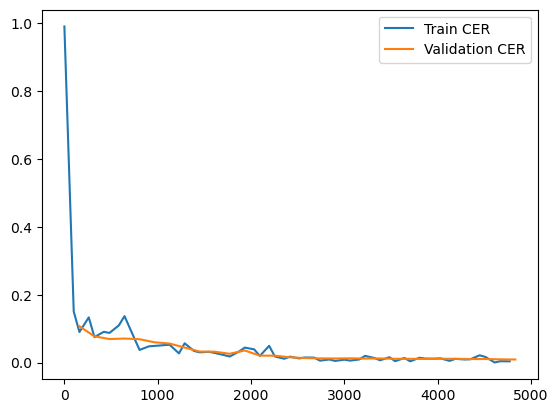

In [9]:
from matplotlib import pyplot as plt

plt.plot(train_steps, train_cer_list, label='Train CER')
plt.plot(val_steps, val_cer_list, label='Validation CER')
plt.legend()
plt.show()

In [10]:
import pickle

# pickle.dump(train_steps, open('train_steps.pkl', 'wb'))
pickle.dump(val_cer_list, open('val_cer_without_CL_and_only_with_target_dataset.pkl', 'wb'))

In [11]:
# torch.save(encoder.state_dict(), config["saved Encoder path"])
# torch.save(decoder.state_dict(), config["saved Decoder path"])

In [12]:
import pickle
import torch
from encoder import Encoder
from Decoder import LSTMAttnDecoder
import os
import json
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Lambda, Grayscale

config = json.load(open('config.json'))["fine-tuning"]
ssl_config = json.load(open('config.json'))["SSL"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
with open(config["token to char"], "rb") as f:
    token_to_char = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder().to(device)
decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
encoder.load_state_dict(torch.load(config["saved Encoder path"]))
decoder.load_state_dict(torch.load(config["saved Decoder path"]))

<All keys matched successfully>

In [14]:
with open(config["char to token"], 'rb') as f:
    char_to_token = pickle.load(f)

SOS_token = char_to_token['<SOS>']
test_dataset_folder = config["test dataset"]

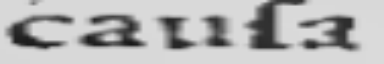

['c', 'a', 'u', 's', 'a', '<EOS>']


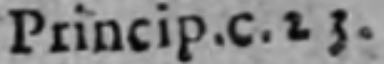

['p', 'r', 'i', 'n', 'c', 'i', 'p', 'e', ',', '<EOS>']


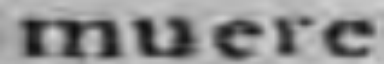

['m', 'u', 'e', 'r', 'e', '<EOS>']


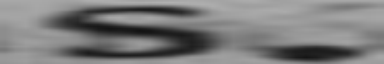

['a', 'l', 't', 'o', '<EOS>']


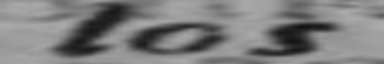

['l', 'o', 'o', 's', '<EOS>']


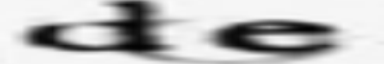

['d', 'e', '<EOS>']


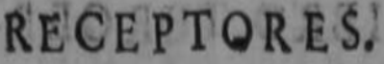

['a', 'e', 'c', 'e', 'r', 'r', 'o', 'a', 's', '<EOS>']


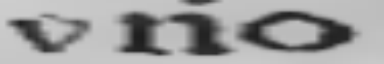

['v', 'i', 'o', '<EOS>']


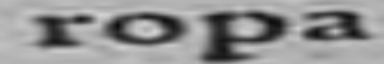

['t', 'o', 'p', 'a', '<EOS>']


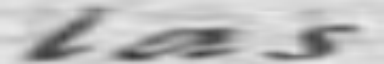

['d', 'a', 'c', 'i', '-', '<EOS>']


In [15]:
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

import random

img_size = (64, 384)

data_transform = transforms.Compose([
            Lambda(lambda img: img.convert("RGB")),
            Grayscale(num_output_channels=3),
            Resize(img_size),
            ToTensor(),  # Convert image to PyTorch Tensor in CHW format
        ])

decoder.eval()

test_data_files = os.listdir(test_dataset_folder)
random.shuffle(test_data_files)

with torch.no_grad():
    for filename in test_data_files[:10]:
        image = Image.open(os.path.join(test_dataset_folder, filename))
        image = data_transform(image)
        display(ToPILImage()(image))
        image_tensor = image.unsqueeze(0).to(device)
        encoder_outputs, decoder_hidden = encoder(image_tensor)
        decoder_input = torch.tensor([[SOS_token]] * image_tensor.size(0)).to(device)
        prediction = []
        for t in range(20):  # Assuming maximum sequence length is 50
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            prediction.append(decoder_input.item())
            if decoder_input.item() == char_to_token['<EOS>']:
                break
        print([token_to_char[i] for i in prediction])

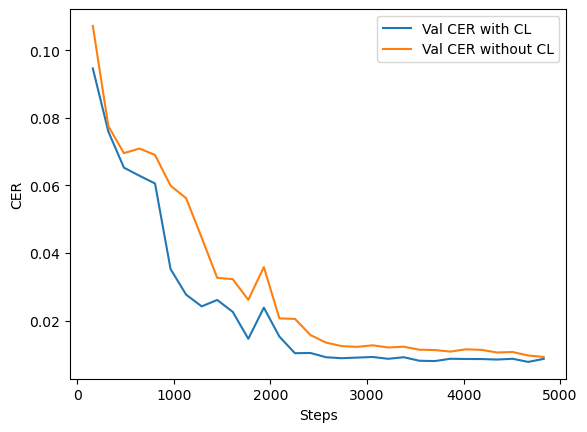

In [18]:
import pickle
from matplotlib import pyplot as plt

with open("val_cer_with_CL_and_only_with_target_dataset.pkl", "rb") as f:
	train_cer_with_CL = pickle.load(f)

with open("val_cer_without_CL_and_only_with_target_dataset.pkl", "rb") as f:
	train_cer_without_CL = pickle.load(f)

with open("train_steps.pkl", "rb") as f:
	train_steps = pickle.load(f)

plt.plot(val_steps, train_cer_with_CL, label='Val CER with CL')
plt.plot(val_steps, train_cer_without_CL, label='Val CER without CL')
plt.xlabel('Steps')
plt.ylabel('CER')
plt.legend()
plt.show()